<a href="https://colab.research.google.com/github/AbhiAadi/DeepONet/blob/main/NN_wt_trunk_using_gstool_for_Double_Integral_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
!pip install gstools

In [106]:
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


In [109]:
m = 100 #sampling points for discretizing functions
n = 150  #number of different functions

In [110]:
seed = MasterRNG(20170519)
def one_function(x):
    model = Gaussian(dim=1, var=2, len_scale=1)  #increase len_scale value to get smoother curves
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [111]:
def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simps(f[:i+1], x[:i+1])
    return result

In [112]:
def derivative_one_function(f, x):
  return np.gradient(f, x)

In [125]:
x = np.linspace(0, 1, m)

U = np.zeros((m, n))
for i in range(n):
    U[:, i] = one_function(x)

# U = np.zeros((m,n))
# for i in range(m):
#   U[:, i ] = np.sin(x)
print(U)

[[ 0.30316768  0.2032731   1.33048281 ...  0.32733511  0.78198478
   0.80677767]
 [ 0.30370067  0.20316837  1.33167997 ...  0.32197392  0.78374384
   0.80909571]
 [ 0.30440129  0.20322861  1.3324637  ...  0.31686817  0.78505063
   0.81096335]
 ...
 [ 0.63530675  0.45524229  0.58161972 ...  1.01048134 -1.06369008
   0.53622649]
 [ 0.62928186  0.451782    0.58378209 ...  1.0228868  -1.08381457
   0.54439098]
 [ 0.62283483  0.44810378  0.58641255 ...  1.03513128 -1.10332199
   0.55294328]]


In [126]:
S = np.zeros((m, n))
for i in range(n):
    S[:, i] =  integrate_one_function(integrate_one_function(U[:, i]))

In [116]:
# for i in range(n):
#    plt.plot(x, U[:, :i], color = 'b')
#    plt.plot(x, S[:, :i], color = 'r')
#    plt.show()

In [127]:
def interate_dataset(m=m, n=n , x=x, U=U, S=S):
    us = np.zeros((n, m))
    ss = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            us[j, :] = U[:, i]
            ss[j, :] = S[j, i]
    return us, ss

us, ss = interate_dataset()
us.shape, ss.shape

((150, 100), (150, 100))

In [128]:
ratio=0.8
train_size = int(len(us)*ratio)
us_train = us[:train_size]
ss_train = ss[:train_size]

us_test = us[train_size:]
ss_test = ss[train_size:]

us_train.shape,ss_train.shape,us_test.shape,ss_test.shape

((120, 100), (120, 100), (30, 100), (30, 100))

In [129]:
def deeponet_model(number_sensor_point, layer_branch, nodes_branch, output_size, activation_branch):
  # Creating branch net
  branch_input = tf.keras.layers.Input(shape = (number_sensor_point), name = 'branch_input')

  branch_layers = []
  x = branch_input
  for i in range(layer_branch -1):
      layer_name = f'branch_{i+1}'
      x = tf.keras.layers.Dense(nodes_branch, activation=activation_branch, name=layer_name)(x)
      branch_layers.append(x)
  branch_output = tf.keras.layers.Dense(output_size, name = 'branch_output')(x)

  branch_net = tf.keras.models.Model(inputs = branch_input, outputs = branch_output)


  deeponet_model = tf.keras.models.Model(inputs=[branch_input], outputs=branch_output)

  return deeponet_model


In [130]:
number_sensor_point = m
layer_branch = 4
nodes_branch = 150
output_size = 100
activation_branch = 'tanh'

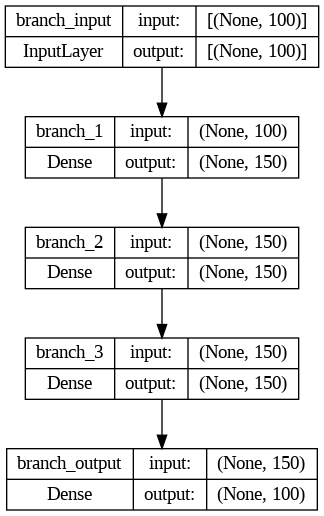

In [131]:
model = deeponet_model(number_sensor_point, layer_branch, nodes_branch, output_size, activation_branch)
tf.keras.utils.plot_model(model,show_shapes=True)

In [132]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
losses = model.fit([us_train],ss_train,epochs=100,batch_size=32,validation_data=([us_test],ss_test))


Epoch 1/100
4/4 [==============================] - 1s 71ms/step - loss: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 1.0089e-04 - val_root_mean_squared_error: 0.0100
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 6.2624e-05 - val_root_mean_squared_error: 0.0079
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 4.6043e-05 - val_root_mean_squared_error: 0.0068
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 4.1065e-05 - val_root_mean_squared_error: 0.0064
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032 - val_loss: 3.7209e-05 - val_root_mean_squared_error: 0.0061
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 3.365

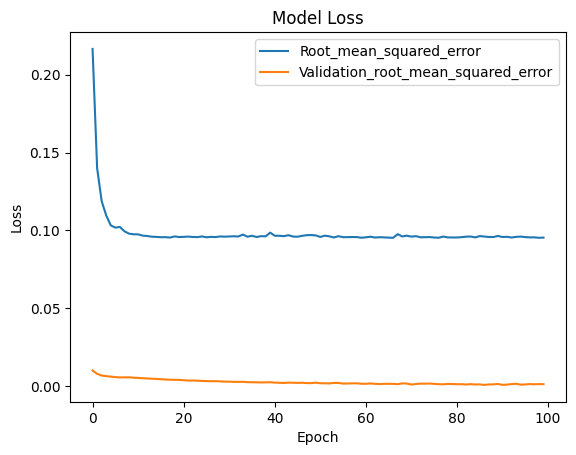

In [137]:
plt.plot(losses.history['root_mean_squared_error'], label='Root_mean_squared_error')
plt.plot(losses.history['val_root_mean_squared_error'], label='Validation_root_mean_squared_error')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(100,)


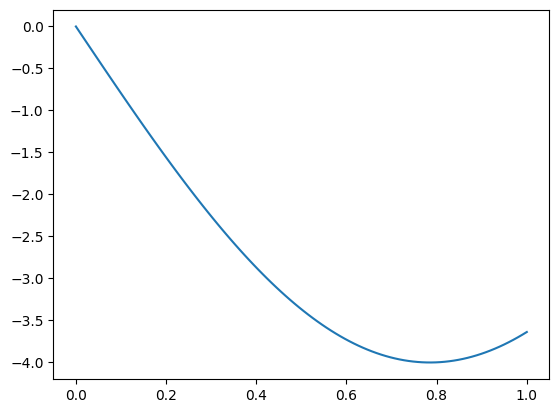

In [145]:
p =100

outp_loc = np.linspace(0,1,p)
my_func = lambda x: -4*np.sin(2*x)
inter = lambda x: np.sin(2*x)
u_t = my_func(x)

s_t = inter(outp_loc)
print(u_t.shape)
plt.plot(x,u_t)
plt.show()

In [147]:

inp_func = np.asarray([u_t])
outp_func = np.asarray(s_t) #output function

# print(outp_func.shape)

# print(inp_func.shape)

# print([inp_func])

1/1 [==============================] - 0s 31ms/step


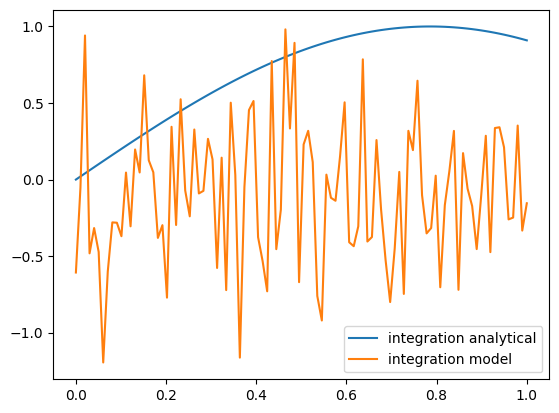

In [153]:
pt = model.predict([inp_func])
# x=np.array([x])
pt=pt.reshape(100,1)
# b=np.zeros((100,1))
# for i in range (100):
#   b[i][0]=0.06

# pt = pt + b


plt.plot(x, s_t, label="integration analytical")
plt.plot(x, pt, label="integration model")
plt.legend();